# 파이썬 기반의 AI를 위한 기초수학, 확률및통계

In [1]:
## 강봉주 
## bonjour.kang@gmail.com
##
## 단순 선형회귀분석
##

In [2]:
# 필요한 패키지
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

import scipy
from scipy import linalg as la
import scipy.stats as ss
import scipy.special

# 한글출력
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 필요한 패키지 2
import statsmodels.api as sm
import statsmodels.formula.api as smf
sm.__version__

'0.10.1'

## 데이터 구성

In [3]:
# [HOUSING]

# 경로 정의
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
df = pd.read_csv(url,sep='\s+',  header=None)

# 컬럼 정보 주기
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
              'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.columns = df.columns.str.lower()

# 데이터 확인
df.loc[:,['rm', 'medv']].head(2)

,rm,medv
0,6.575,24.0
1,6.421,21.6


In [4]:
#
# 단순 회귀 적합
#

# 데이터 정의
X = df["rm"]
y = df["medv"]
X = sm.add_constant(X)

# 모델 정의
model = sm.OLS(y, X)
# 모델 적합
fit = model.fit()
# 모델 요약
print(fit.summary())


                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Wed, 11 Mar 2020   Prob (F-statistic):           2.49e-74
Time:                        10:23:31   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -34.6706      2.650    -13.084      0.0

## 오차 분산의 계산

In [5]:
# 데이터 구성
sample_size = 100

np.random.seed(123)
# 중복 허용
index = np.random.choice(np.arange(len(df)), size=sample_size)

X = df.loc[index, "rm"]
y = df.loc[index, "medv"]
X = sm.add_constant(X)

In [6]:
# 중복 추출된 관측값 번호 확인
dups = X.index.value_counts()
dups[dups > 1]

47     2
208    2
322    2
411    2
180    2
253    2
305    2
96     2
365    2
106    2
dtype: int64

In [7]:
#  모델 적합
fit = sm.OLS(y, X).fit()
pred = fit.predict(sm.add_constant(df.loc[index, "rm"]))

# RMSE 계산
MSE = np.sum((y-pred)**2) / (sample_size-2)
RMSE = np.sqrt(MSE)
RMSE.round(3)

7.022

In [8]:
# 함수 결과와 확인
np.sqrt(fit.mse_resid).round(3)

7.022

## $R^2$ 의 계산

In [9]:
# 데이터 구성
sample_size = 100

np.random.seed(123)
# 중복 허용
index = np.random.choice(np.arange(len(df)), size=sample_size)

X = df.loc[index, "rm"]
y = df.loc[index, "medv"]
X = sm.add_constant(X)

In [10]:
#  모델 적합
fit = sm.OLS(y, X).fit()
pred = fit.predict(sm.add_constant(df.loc[index, "rm"]))

# R^2 계산
SST = np.sum((y-np.mean(y))**2)
SSE = np.sum((y-pred)**2)
SSR = SST - SSE
R2 = SSR/SST
R2.round(3)

0.394

In [11]:
# adj R^2 계산
adjR2 = 1 - (1-R2)*(sample_size-1) / (sample_size - 2)
adjR2.round(3)

0.388

In [12]:
# 결과값 확인
res = np.array([fit.rsquared, fit.rsquared_adj])
res.round(3)

array([0.394, 0.388])

## 회귀계수의 신뢰구간 계산

In [13]:
# 적합된 모델 정보로 부터
# 추정된 회귀 직선의 기울기
beta = fit.params[1]

# t 분포의 분위수 계산
alpha = 0.05
t = ss.t.ppf(1-alpha/2, df=sample_size-2)

# 오차표준오차 계산
sigma = np.sqrt(fit.mse_resid)

# 데이터 제곱합 계산
x = X.iloc[:,1]
c = np.sum((x-np.mean(x))**2)

# 신뢰구간 계산
bse = sigma / np.sqrt(c)
conf = np.array([beta - t*bse, beta + t*bse])
conf.round(3)

array([5.542, 9.211])

In [14]:
# 결과 확인
fit.conf_int(alpha=0.05).loc['rm', :].round(3)

0    5.542
1    9.211
Name: rm, dtype: float64

## 회귀계수의 추론

In [15]:
# 검정 통계량: t0 값 계산
tvalue = beta / (sigma / np.sqrt(c))

# p-value 계산: tvalue > 0 이므로
pvalue = 2*(1 - ss.t.cdf(tvalue, df=sample_size-2))

np.array([tvalue, pvalue]).round(3)

array([7.98, 0.  ])

In [16]:
# 결과 확인
np.array([fit.tvalues['rm'], fit.pvalues['rm']]).round(3)

array([7.98, 0.  ])

## 분산 분석표의 작성

In [17]:
# f 통계량의 계산
fvalue = fit.mse_model / fit.mse_resid

# p-value의 계산
pvalue = 1 - ss.f.cdf(fvalue, dfn=fit.df_model, dfd= fit.df_resid)

np.array([fvalue, pvalue]).round(3)

array([63.674,  0.   ])

In [18]:
# 결과 확인
np.array([fit.fvalue, fit.f_pvalue]).round(3)

array([63.674,  0.   ])

## 회귀직선에 대한 신뢰구간

In [19]:
# 적합된 회귀 직선
yhat = X @ fit.params

# t 분위수 계산
alpha = 0.05
t = ss.t.ppf(1-alpha/2, fit.df_resid)

# RMSE 계산
sigma =  np.sqrt(fit.mse_resid)

# 회귀직선 표준오차 계산
c = np.sum((X.iloc[:, 1]-np.mean(X.iloc[:, 1]))**2)
yhat_se = sigma * np.sqrt(1/fit.nobs + (X.iloc[:, 1]-np.mean(X.iloc[:, 1]))**2/c)

# 회귀직선의 신뢰구간
lower = yhat-t*yhat_se
upper = yhat+t*yhat_se
np.array([lower, yhat, upper]).round(3).T[:2, : ]

array([[-2.505,  2.717,  7.938],
       [15.304, 17.286, 19.267]])

In [20]:
# 결과 확인
res  = fit.get_prediction(X)
print(res.summary_frame().head(2))

          mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
365   2.716666  2.631080      -2.504627       7.937960    -12.164543   
382  17.285652  0.998497      15.304167      19.267137      3.210327   

     obs_ci_upper  
365     17.597876  
382     31.360977  


## 회귀 진단

In [21]:
# 표준화 잔차(내부 스튜던트화 잔차) 계산
import statsmodels.formula.api as smf

#  데이터 구성
sample_size = 100

np.random.seed(123)
index = np.random.choice(np.arange(len(df)), size=sample_size, replace=False)
sdf = df.loc[index]

# 회귀 직선 적합
res = smf.ols('medv ~ rm', data=sdf).fit()

# 결과 확인
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     57.04
Date:                Wed, 11 Mar 2020   Prob (F-statistic):           2.25e-11
Time:                        10:23:31   Log-Likelihood:                -340.44
No. Observations:                 100   AIC:                             684.9
Df Residuals:                      98   BIC:                             690.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -26.8206      6.671     -4.020      0.0

In [22]:
# 표준화 잔차 또는 내부 스튜던트화 잔차 계산
x = sdf['rm']
x_centered = np.array(x - x.mean())**2
c = np.sum(x_centered)
ti = res.resid / np.sqrt((res.mse_resid)*(1-(1/res.nobs+x_centered/c)))
ti.head(3).round(3)

410   -0.538
85     0.101
280    1.412
dtype: float64

In [23]:
# 결과 확인
infl = res.get_influence()
r_standard = infl.resid_studentized
r_standard[:3].round(3)

array([-0.538,  0.101,  1.412])

In [24]:
# 독립성 검정
# 더빈-왓슨 통계량 계산
dw = np.nansum((res.resid - res.resid.shift(1))**2)/np.sum(res.resid**2)
dw.round(3)

1.966

## 정규성 검정

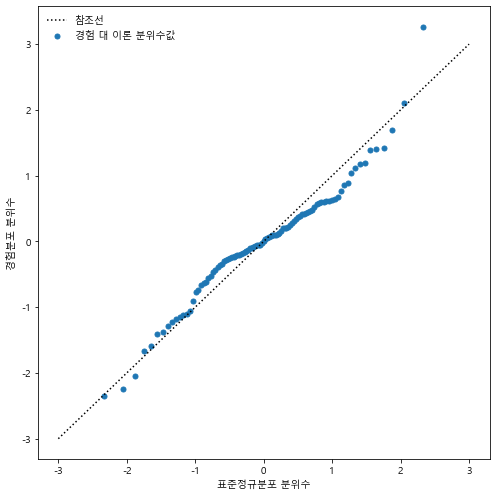

In [25]:
## 분위수-분위수 그림(QQ plot)
# 데이터 구성
x_values = r_standard

# 확률 정의
m = 100
prob = np.arange(1, m+1)/100

# 이론적인 분위수 값
norm_ppf = ss.norm.ppf(prob)

# 경험 분포에 의한 확률 값
empirical_ppf = np.quantile(x_values, q=prob)

# 최소값, 최대값 지정
min = -3
max = 3

# 그래프로 확인
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(norm_ppf, empirical_ppf, s=5**2, label='경험 대 이론 분위수값')
ax.plot([min, max],[min, max], color='k', ls=':', label='참조선')

ax.set_xlabel('표준정규분포 분위수')
ax.set_ylabel('경험분포 분위수')

plt.legend(loc='best', frameon=False)

plt.tight_layout()

In [26]:
# 검정 통계량에 의한 검정
# 사피로-윌크 검정(Shapiro-Wilk test)
np.round(ss.shapiro(x_values), 3)

array([0.936, 0.   ])

In [27]:
# 콜모고로프-스미르노프(Kolmogorov-Smirnov) 검정
np.round(ss.kstest(x_values, cdf='norm'), 3)

array([0.112, 0.15 ])